In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from scipy.io import loadmat

In [2]:
# Read the Excel file
file_name = 'Data_4_Import_REST.xlsx'
excel_sheet_name = 'Depression Rest'
file_path = os.path.join("Depression_Study", "depression_data", file_name)
df_raw = pd.read_excel(file_path, sheet_name=excel_sheet_name)

# Extract healthy and depressed samples
healthy_sample = df_raw[df_raw.iloc[:, 1] == 99].iloc[:, 0].tolist()
depressed_sample = df_raw[df_raw.iloc[:, 1] != 99].iloc[:, 0].tolist()

In [3]:
# Load CSER values from MAT file
cser_values = loadmat("cser_values.mat")

# Extract field names from cser_open and cser_closed
field_names_open = [int(name[1:]) for name in cser_values['cser_open'].dtype.names]
field_names_closed = [int(name[1:]) for name in cser_values['cser_closed'].dtype.names]

# Extract values from the CSER data
cser_open = np.array([value[0][0] for sublist in cser_values['cser_open'][0] for value in sublist])
cser_closed = np.array([value[0][0] for sublist in cser_values['cser_closed'][0] for value in sublist])

# Extract band values into separate list for each band
cser_band_open = [np.array([value[0][i] for sublist in cser_values['cser_band_open'][0] for value in sublist]) for i in range(6)]
cser_band_closed = [np.array([value[0][i] for sublist in cser_values['cser_band_closed'][0] for value in sublist]) for i in range(6)]

# Extract CSER from the for each of the 60 sources
cser_source_open = [np.array([value[0][i] for sublist in cser_values['cser_source_open'][0] for value in sublist]) for i in range(60)]
cser_source_closed = [np.array([value[0][i] for sublist in cser_values['cser_source_closed'][0] for value in sublist]) for i in range(60)]

# Extract CSER from the for each of the 60 sources
cser_source_band_open = np.array([[np.array([value[j][i] for sublist in cser_values['cser_source_band_open'][0] for value in sublist]) for i in range(60)] for j in range(6)])
cser_source_band_closed = np.array([[np.array([value[j][i] for sublist in cser_values['cser_source_band_closed'][0] for value in sublist]) for i in range(60)] for j in range(6)])
# i source x j band

# Extract AAL source names
source_names = [(cser_values['source_names'][i][0][0]) for i in range(60)]

In [4]:
# print(df_raw.columns.tolist())
df = df_raw.copy()
df = df.drop(columns=['MDD_note', 'HamD'])
# print(df.columns.tolist())

missing_ids_open = set(df['id']) - set(field_names_open)
df = df[~df['id'].isin(missing_ids_open)]

df['eyes'] = 'open'
df['area'] = 'brain'
df['band'] = 'broadband'
df['CSER'] = np.nan

# df['depressed'] = df.iloc[:, 1].apply(lambda x: 1 if x != 99 else 0)
df['depressed'] = df.iloc[:, 1].apply(lambda x: 1 if x == 1 else 0)

# Reorder columns: insert ['eyes', 'area', 'band', 'CSER'] after 'id'
cols = df.columns.tolist()
insert_cols = ['eyes', 'area', 'band', 'CSER']
# Remove if already present to avoid duplication
for c in insert_cols:
    if c in cols:
        cols.remove(c)
id_idx = cols.index('id')
new_cols = cols[:id_idx+1] + insert_cols + cols[id_idx+1:]
df = df[new_cols]

print(df.columns.tolist())
print()

df_copy = df.copy()

print("DF Shape:", df.shape)

# OPEN / BRAIN / BROADBAND
for i, row in df.iterrows():
    id_value = row['id']
    if id_value in field_names_open:
        df.at[i, 'CSER'] = cser_open[field_names_open.index(id_value)]

print("DF Shape after inserting [open / brain / broadband]:", df.shape)

# CLOSED / BRAIN / BROADBAND
df_closed = df_copy.copy()
df_closed['eyes'] = 'closed'
df_closed['area'] = 'brain'
df_closed['band'] = 'broadband'
# Add CSER values for closed eyes
for i, row in df_closed.iterrows():
    id_value = row['id']
    if id_value in field_names_closed:
        df_closed.at[i, 'CSER'] = cser_closed[field_names_closed.index(id_value)]
df = pd.concat([df, df_closed], ignore_index=True)

print("DF Shape after inserting [closed / brain / broadband]:", df.shape)

# open / brain / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12
# band_names = ["1-4","4-8","8-12","12-30","30-100"]
band_names = ["1-4","4-8","8-12","12-30","30-100","1-12"]
for i, band in enumerate(band_names):
    df_band = df_copy.copy()
    df_band['eyes'] = 'open'
    df_band['area'] = 'brain'
    df_band['band'] = band
    for j, row in df_band.iterrows():
        id_value = row['id']
        if id_value in field_names_open:
            data_index = field_names_open.index(id_value)
            df_band.at[j, 'CSER'] = cser_band_open[i][data_index]
    df = pd.concat([df, df_band], ignore_index=True)

print("DF Shape after inserting [open / brain / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12]:", df.shape)

# closed / brain / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12
for i, band in enumerate(band_names):
    df_band = df_copy.copy()
    df_band['eyes'] = 'closed'
    df_band['area'] = 'brain'
    df_band['band'] = band
    for j, row in df_band.iterrows():
        id_value = row['id']
        if id_value in field_names_closed:
            data_index = field_names_closed.index(id_value)
            df_band.at[j, 'CSER'] = cser_band_closed[i][data_index]
    df = pd.concat([df, df_band], ignore_index=True)

print("DF Shape after inserting [closed / brain / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12]:", df.shape)

# open / src01, src02, ..., src60 / broadband
for i in range(60):
    df_source = df_copy.copy()
    df_source['eyes'] = 'open'
    df_source['area'] = f'src{i+1:02d}_{source_names[i]}'
    df_source['band'] = 'broadband'
    for j, row in df_source.iterrows():
        id_value = row['id']
        if id_value in field_names_open:
            data_index = field_names_open.index(id_value)
            df_source.at[j, 'CSER'] = cser_source_open[i][data_index]
    df = pd.concat([df, df_source], ignore_index=True)

print("DF Shape after inserting [open / src01, src02, ..., src60 / broadband]:", df.shape)

# closed / src01, src02, ..., src60 / broadband
for i in range(60):
    df_source = df_copy.copy()
    df_source['eyes'] = 'closed'
    df_source['area'] = f'src{i+1:02d}_{source_names[i]}'
    df_source['band'] = 'broadband'
    for j, row in df_source.iterrows():
        id_value = row['id']
        if id_value in field_names_closed:
            data_index = field_names_closed.index(id_value)
            df_source.at[j, 'CSER'] = cser_source_closed[i][data_index]
    df = pd.concat([df, df_source], ignore_index=True)

print("DF Shape after inserting [closed / src01, src02, ..., src60 / broadband]:", df.shape)

# open / src01, src02, ..., src60 / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12
for i in range(60):
    for j, band in enumerate(band_names):
        df_source_band = df_copy.copy()
        df_source_band['eyes'] = 'open'
        df_source_band['area'] = f'src{i+1:02d}_{source_names[i]}'
        df_source_band['band'] = band
        for k, row in df_source_band.iterrows():
            id_value = row['id']
            if id_value in field_names_open:
                data_index = field_names_open.index(id_value)
                df_source_band.at[k, 'CSER'] = cser_source_band_open[j][i][data_index]
        df = pd.concat([df, df_source_band], ignore_index=True)

print("DF Shape after inserting [open / src01, src02, ..., src60 / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12]:", df.shape)

# closed / src01, src02, ..., src60 / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12
for i in range(60):
    for j, band in enumerate(band_names):
        df_source_band = df_copy.copy()
        df_source_band['eyes'] = 'closed'
        df_source_band['area'] = f'src{i+1:02d}_{source_names[i]}'
        df_source_band['band'] = band
        for k, row in df_source_band.iterrows():
            id_value = row['id']
            if id_value in field_names_closed:
                data_index = field_names_closed.index(id_value)
                df_source_band.at[k, 'CSER'] = cser_source_band_closed[j][i][data_index]
        df = pd.concat([df, df_source_band], ignore_index=True)

print("DF Shape after inserting [closed / src01, src02, ..., src60 / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12]:", df.shape)

# open, closed / frontal, occipital, parietal, sensorimotor, temporal / broadband, 1-4, 4-8, 8-12, 12-30, 30-100, 1-12
region_map = {
    'frontal': [f'src{i+1:02d}_{source_names[i]}' for i in range(2, 16)] + [f'src{i:02d}_{source_names[i]}' for i in range(18, 24)],
    'occipital': [f'src{i+1:02d}_{source_names[i]}' for i in range(24, 36)],
    'parietal': [f'src{i+1:02d}_{source_names[i]}' for i in range(38, 50)],
    'sensorimotor': [f'src{i+1:02d}_{source_names[i]}' for i in [0, 1, 16, 17, 36, 37]],
    'temporal': [f'src{i+1:02d}_{source_names[i]}' for i in range(50, 60)]
}

def map_region(area):
    for region, sources in region_map.items():
        if area in sources:
            return region
    return area

df_avg = df[df['area'] != 'brain'].copy()
df_avg['area'] = df_avg['area'].apply(map_region)
group_cols = ['id', 'eyes', 'area', 'band']
agg_dict = {col: 'first' for col in df_avg.columns if col not in group_cols + ['CSER']}
agg_dict['CSER'] = 'mean'
df_avg = df_avg.groupby(group_cols, as_index=False).agg(agg_dict)
df = pd.concat([df, df_avg], ignore_index=True)

print("DF Shape after inserting [open, closed / frontal, ..., temporal / broadband, 1-4, ..., 30-100, 1-12]:", df.shape)

# open / brain, frontal, ..., src60 / 1_12m  # mean estimate for 1-12 band
# df_temp = df.copy()
# df_temp = df_temp[~df_temp['band'].isin(['broadband', '12-30', '30-100'])]
# df_temp['band'] = '1-12m'

# group_cols = ['id', 'eyes', 'area', 'band']
# agg_dict = {col: 'first' for col in df_temp.columns if col not in group_cols + ['CSER']}
# agg_dict['CSER'] = 'mean'
# df_temp = df_temp.groupby(group_cols, as_index=False).agg(agg_dict)
# df = pd.concat([df, df_temp], ignore_index=True)

# print("DF Shape after inserting [open / brain, frontal, ..., src60 / 1-12m]:", df.shape)

# sort 'band' column as per the specified order
band_order = ['broadband', '1-12', '1-4', '4-8', '8-12', '12-30', '30-100']
df['band'] = pd.Categorical(df['band'], categories=band_order, ordered=True)

df = df.sort_values(by=['id', 'eyes', 'area', 'band']).reset_index(drop=True)
print()
print(df)

['id', 'eyes', 'area', 'band', 'CSER', 'MDD', 'sex', 'age', 'BDI', 'BDI_Anh', 'BDI_Mel', 'TAI', 'depressed']

DF Shape: (119, 13)
DF Shape after inserting [open / brain / broadband]: (119, 13)
DF Shape after inserting [closed / brain / broadband]: (238, 13)
DF Shape after inserting [open / brain / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12]: (952, 13)
DF Shape after inserting [closed / brain / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12]: (1666, 13)
DF Shape after inserting [open / src01, src02, ..., src60 / broadband]: (8806, 13)
DF Shape after inserting [closed / src01, src02, ..., src60 / broadband]: (15946, 13)
DF Shape after inserting [open / src01, src02, ..., src60 / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12]: (58786, 13)
DF Shape after inserting [closed / src01, src02, ..., src60 / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12]: (101626, 13)
DF Shape after inserting [open, closed / frontal, ..., temporal / broadband, 1-4, ..., 30-100, 1-12]: (119952, 13)

         id    eyes      area       band      CSER  M

In [5]:
# List outliers beyond 75th percentile and below 25th percentile
def identify_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return series[(series < lower_bound) | (series > upper_bound)]
outliers = identify_outliers(df['CSER'])
print("\nOutliers in CSER values:")
print(outliers)

# # Drop outliers from the DataFrame if they exist
outlier_ids = ['527','535']
ids_in_df = df['id'].astype(str).isin(outlier_ids)
if ids_in_df.any():
    df = df[~ids_in_df]
print("\nDropped outliers with IDs:", outlier_ids)
print("DF Shape after dropping outliers:", df.shape)


Outliers in CSER values:
21       -3.495830
28       -3.362662
35       -3.540515
42       -3.487562
49       -3.201105
            ...   
119833   -3.787678
119840   -3.184133
119847   -3.083440
119861   -3.258471
119868   -3.095916
Name: CSER, Length: 4865, dtype: float64

Dropped outliers with IDs: ['527', '535']
DF Shape after dropping outliers: (117936, 13)


In [11]:
# Make 'depressed' column equal to 1 if 'MDD' column is 1, else 0
# df['depressed'] = df['MDD'].apply(lambda x: 'depressed' if x == 1 else 'healthy')
df['depressed'] = df['MDD'].apply(lambda x: 1 if x == 1 else 0)

In [12]:
cser_mean_band_area = df.groupby(['eyes', 'depressed', 'band', 'area'])['CSER'].mean().reset_index()
cser_mean_band_area_pivot = cser_mean_band_area.pivot_table(index=['eyes', 'depressed'], columns=['band', 'area'], values='CSER')
print(cser_mean_band_area_pivot)

band             broadband                                             \
area                 brain   frontal occipital  parietal sensorimotor   
eyes   depressed                                                        
closed 0         -2.687294 -2.549629 -2.647067 -3.153220    -2.987432   
       1         -2.593517 -2.517291 -2.462259 -3.026858    -2.892840   
open   0         -2.790830 -2.604666 -2.842297 -3.279040    -3.063905   
       1         -2.692933 -2.518995 -2.708977 -3.188497    -2.997774   

band                                                                        \
area             src01_Precentral_L src02_Precentral_R src03_Frontal_Sup_L   
eyes   depressed                                                             
closed 0                  -3.198607          -3.024440           -2.956341   
       1                  -3.046338          -2.962898           -2.827579   
open   0                  -3.235430          -3.089493           -2.949463   
       1            

C:\Users\lukad\AppData\Local\Temp\ipykernel_7288\724770110.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cser_mean_band_area = df.groupby(['eyes', 'depressed', 'band', 'area'])['CSER'].mean().reset_index()
C:\Users\lukad\AppData\Local\Temp\ipykernel_7288\724770110.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  cser_mean_band_area_pivot = cser_mean_band_area.pivot_table(index=['eyes', 'depressed'], columns=['band', 'area'], values='CSER')


In [13]:
df_brain = df[df['area'] == 'brain']
cser_mean_band = df_brain.groupby(['eyes', 'depressed', 'band'])['CSER'].mean().reset_index()
cser_mean_band_pivot = cser_mean_band.pivot_table(index=['eyes', 'depressed'], columns=['band'], values='CSER')
print(cser_mean_band_pivot)

band              broadband      1-12       1-4       4-8      8-12     12-30  \
eyes   depressed                                                                
closed 0          -2.687294 -0.079978 -0.017039 -0.033753 -0.029186 -0.252512   
       1          -2.593517 -0.076736 -0.017068 -0.033911 -0.025757 -0.239085   
open   0          -2.790830 -0.100172 -0.020323 -0.040414 -0.039435 -0.273422   
       1          -2.692933 -0.097870 -0.019864 -0.040193 -0.037813 -0.260202   

band                30-100  
eyes   depressed            
closed 0         -1.464433  
       1         -1.410928  
open   0         -1.508263  
       1         -1.451730  


C:\Users\lukad\AppData\Local\Temp\ipykernel_7288\794499356.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cser_mean_band = df_brain.groupby(['eyes', 'depressed', 'band'])['CSER'].mean().reset_index()
C:\Users\lukad\AppData\Local\Temp\ipykernel_7288\794499356.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  cser_mean_band_pivot = cser_mean_band.pivot_table(index=['eyes', 'depressed'], columns=['band'], values='CSER')


In [14]:
df_broadband = df[df['band'] == 'broadband']
cser_mean_area = df_broadband.groupby(['eyes', 'depressed', 'area'])['CSER'].mean().reset_index()
# Create cser_mean_area_diff DataFrame which for each 'depressed' and 'healthy' pair, adds a row with the difference between the two
cser_mean_area_diff = cser_mean_area.groupby(['eyes', 'area']).apply(lambda x: x['CSER'].diff().iloc[-1]).reset_index()
cser_mean_area_diff['depressed'] = 'difference'

# Merge the difference row with the original DataFrame
cser_mean_area = pd.concat([cser_mean_area, cser_mean_area_diff], ignore_index=True).reset_index(drop=True)
print(cser_mean_area)

cser_mean_area_pivot = cser_mean_area.pivot_table(index=['eyes', 'depressed'], columns=['area'], values='CSER')
print(cser_mean_area_pivot)

       eyes   depressed                       area      CSER         0
0    closed           0                      brain -2.687294       NaN
1    closed           0                    frontal -2.549629       NaN
2    closed           0                  occipital -2.647067       NaN
3    closed           0                   parietal -3.153220       NaN
4    closed           0               sensorimotor -2.987432       NaN
..      ...         ...                        ...       ...       ...
391    open  difference  src57_Temporal_Pole_Mid_L       NaN  0.151913
392    open  difference  src58_Temporal_Pole_Mid_R       NaN  0.073106
393    open  difference       src59_Temporal_Inf_L       NaN  0.123877
394    open  difference       src60_Temporal_Inf_R       NaN  0.060234
395    open  difference                   temporal       NaN  0.132622

[396 rows x 5 columns]
area                 brain   frontal  occipital  parietal  sensorimotor  \
eyes   depressed                                 

C:\Users\lukad\AppData\Local\Temp\ipykernel_7288\3098914950.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cser_mean_area_diff = cser_mean_area.groupby(['eyes', 'area']).apply(lambda x: x['CSER'].diff().iloc[-1]).reset_index()


In [15]:
df['intercept'] = 1
df['age_squared'] = df['age'] ** 2
if df['sex'].max() == 2:
    df['sex'] = df['sex'] - 1

# Perform regression analysis for each combination of eyes, area, and band
variables = ['intercept', 'depressed', 'BDI', 'BDI_Anh', 'BDI_Mel', 'TAI', 'sex', 'age', 'age_squared']
rlm_results = pd.DataFrame(columns=['eyes', 'area', 'band', 'variable', 'p_value', 't_value', 'p_significant', 't_significant'])

for eyes in ['open', 'closed']:
    for area in df['area'].unique():
        for band in df['band'].unique():
            # Run sm.RLM for each subset of the DataFrame
            subset = df[(df['eyes'] == eyes) & (df['area'] == area) & (df['band'] == band)]
            if subset.empty:
                continue
            model = sm.RLM(subset['CSER'], subset[variables], missing='drop', M=sm.robust.norms.HuberT())
            results = model.fit()
            # print(results.summary())
            for var in variables[1:]:
                p_significant = results.pvalues[var] <= 0.05
                t_significant = abs(results.tvalues[var]) >= 1.7
                new_permutation = pd.DataFrame([{
                    'eyes': eyes,
                    'area': area,
                    'band': band,
                    'variable': var,
                    'p_value': results.pvalues[var],
                    't_value': results.tvalues[var],
                    'p_significant': p_significant,
                    't_significant': t_significant
                }])
                rlm_results = pd.concat([rlm_results, new_permutation], ignore_index=True)

print(rlm_results)

C:\Users\lukad\AppData\Local\Temp\ipykernel_7288\512448008.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rlm_results = pd.concat([rlm_results, new_permutation], ignore_index=True)


        eyes      area       band     variable   p_value   t_value  \
0       open     brain  broadband    depressed  0.677731  0.415562   
1       open     brain  broadband          BDI  0.083110 -1.732918   
2       open     brain  broadband      BDI_Anh  0.823258  0.223357   
3       open     brain  broadband      BDI_Mel  0.356191  0.922647   
4       open     brain  broadband          TAI  0.148762  1.443919   
...      ...       ...        ...          ...       ...       ...   
7387  closed  temporal     30-100      BDI_Mel  0.180092  1.340470   
7388  closed  temporal     30-100          TAI  0.052182  1.941633   
7389  closed  temporal     30-100          sex  0.281578 -1.076781   
7390  closed  temporal     30-100          age  0.562496 -0.579138   
7391  closed  temporal     30-100  age_squared  0.534880  0.620575   

     p_significant t_significant  
0            False         False  
1            False          True  
2            False         False  
3            False 

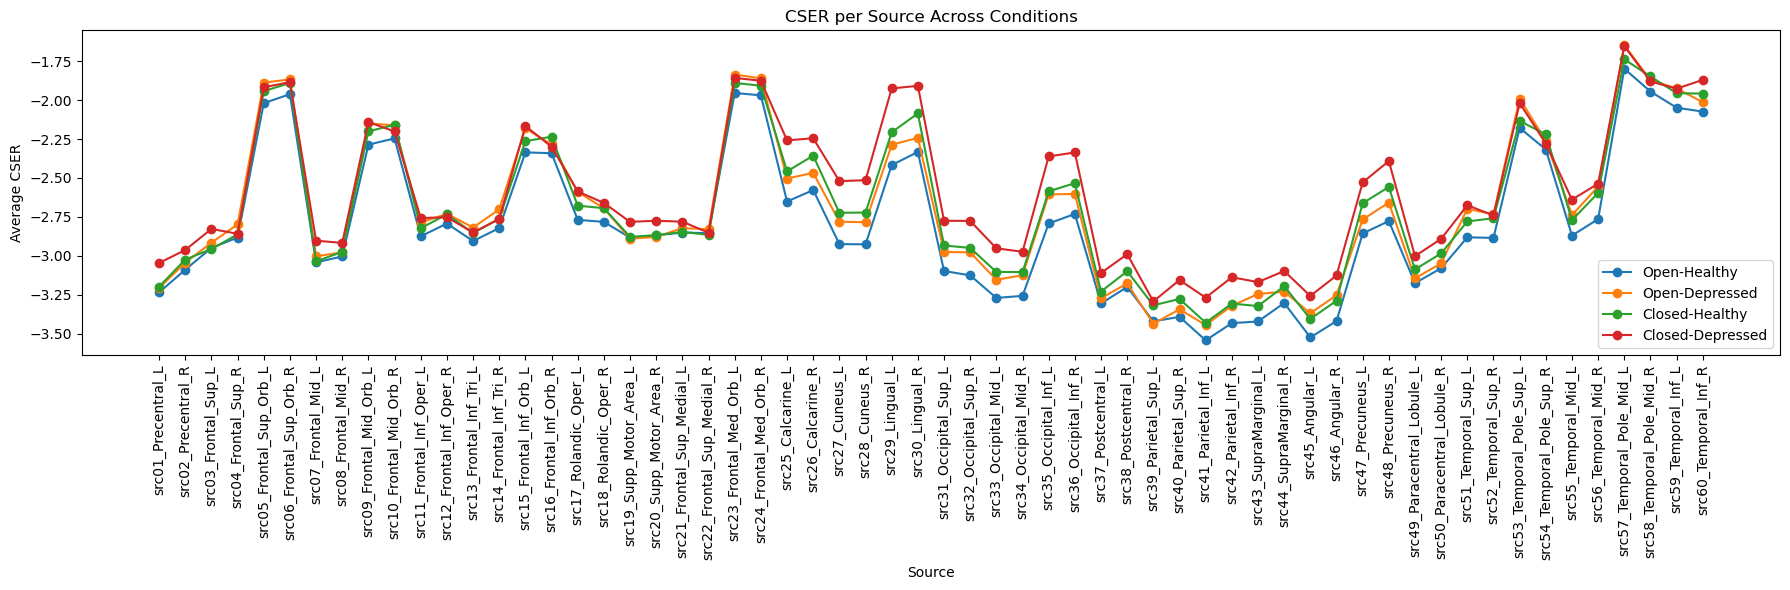

In [18]:
conditions = [
    ('open', 0),
    ('open', 1),
    ('closed', 0),
    ('closed', 1)
]
condition_labels = [
    'Open-Healthy',
    'Open-Depressed',
    'Closed-Healthy',
    'Closed-Depressed'
]
source_indices = np.arange(1, 61)

plt.figure(figsize=(18, 6))
for i, (eyes, depressed) in enumerate(conditions):
    # Filter for the current condition, broadband band, and source areas
    mask = (
        (df['eyes'] == eyes) &
        (df['depressed'] == depressed) &
        (df['band'] == 'broadband') &
        (df['area'].str.startswith('src'))
    )
    # Group by source and take the mean CSER across all subjects for each source
    avg = (
        df.loc[mask]
        .groupby('area')['CSER']
        .mean()
        .reindex([f'src{idx+1:02d}_{source_names[idx]}' for idx in range(60)])
        .values
    )
    plt.plot(source_indices, avg, marker='o', label=condition_labels[i])

plt.xticks(source_indices, [f'src{idx+1:02d}_{source_names[idx]}' for idx in range(60)], rotation=90)
plt.xlabel('Source')
plt.ylabel('Average CSER')
plt.title('CSER per Source Across Conditions')
plt.legend()
plt.tight_layout()
plt.show()

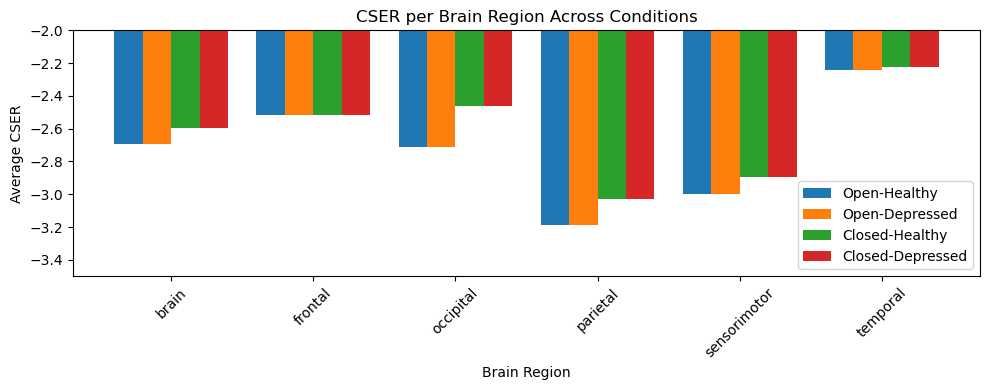

In [22]:
plt.figure(figsize=(10, 4))
for i, (eyes, health) in enumerate(conditions):
    mask = (
        (df['eyes'] == eyes) &
        (df['depressed'] == depressed) &
        (df['band'] == 'broadband') &
        (df['area'].str.startswith('src') == False)
    )

    region_avgs = df.loc[mask, :].groupby('area')['CSER'].mean().reset_index()
    plt.bar(
        np.arange(len(region_avgs)) + i*0.2,
        region_avgs['CSER'],
        width=0.2,
        label=condition_labels[i]
    )

plt.xticks(np.arange(len(region_avgs)) + 0.3, region_avgs['area'], rotation=45)
plt.ylim(-3.5, -2)
plt.xlabel('Brain Region')
plt.ylabel('Average CSER')
plt.title('CSER per Brain Region Across Conditions')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

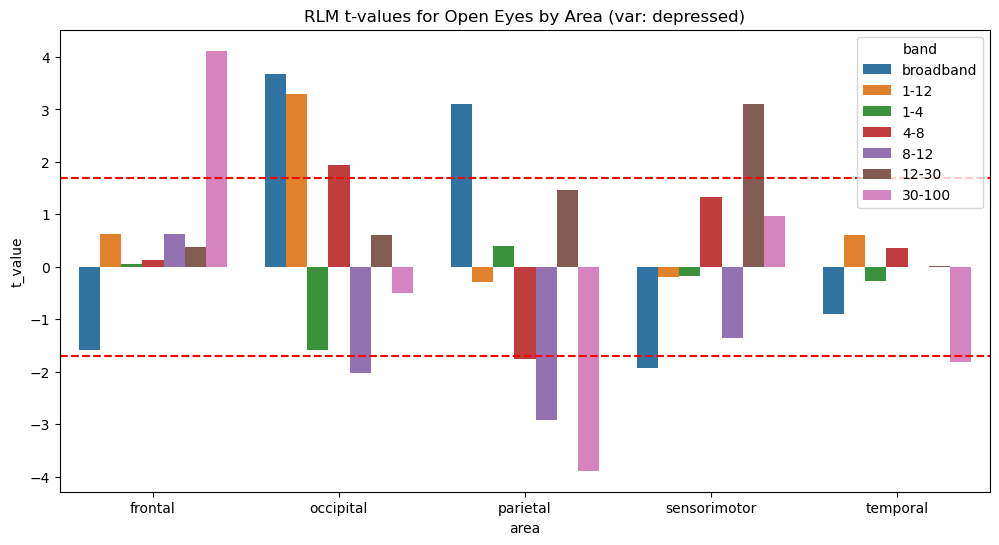

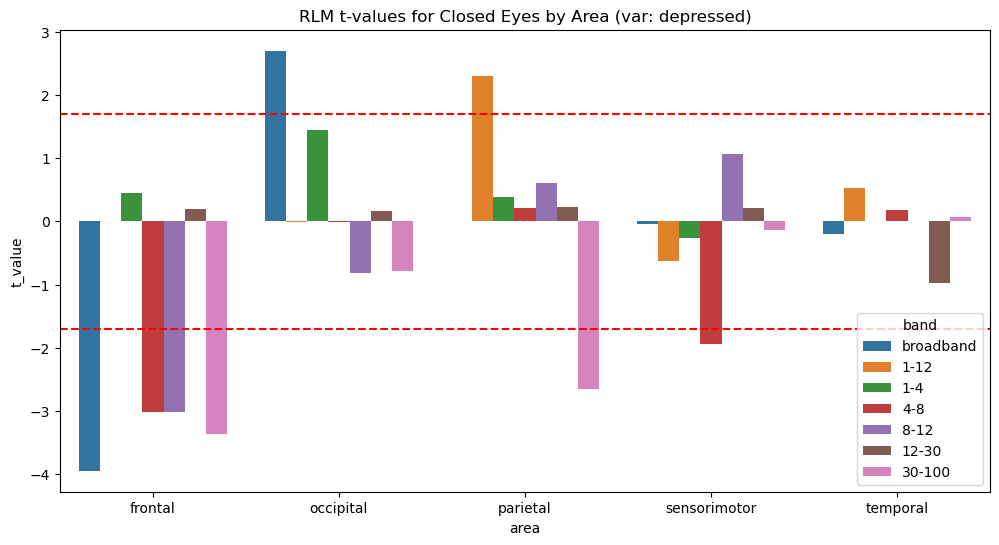

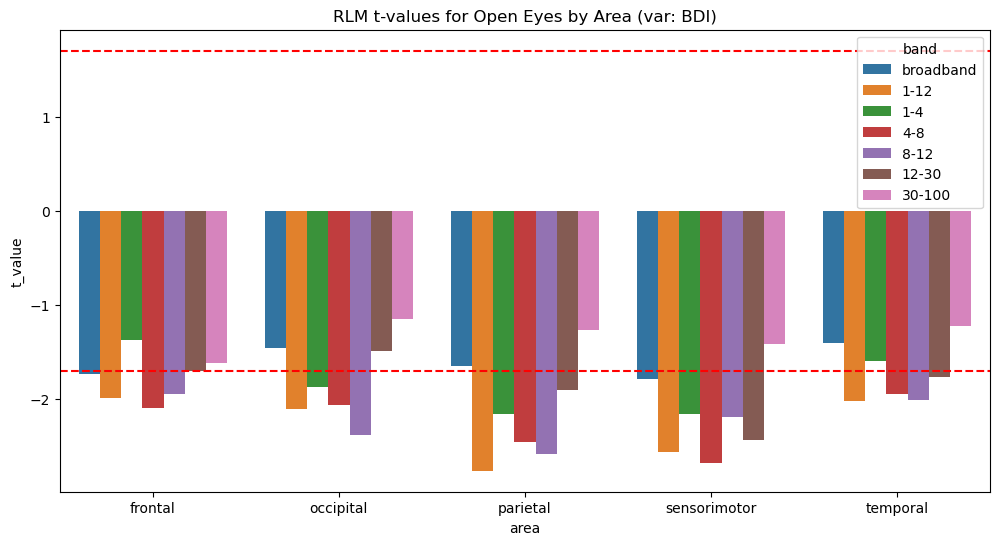

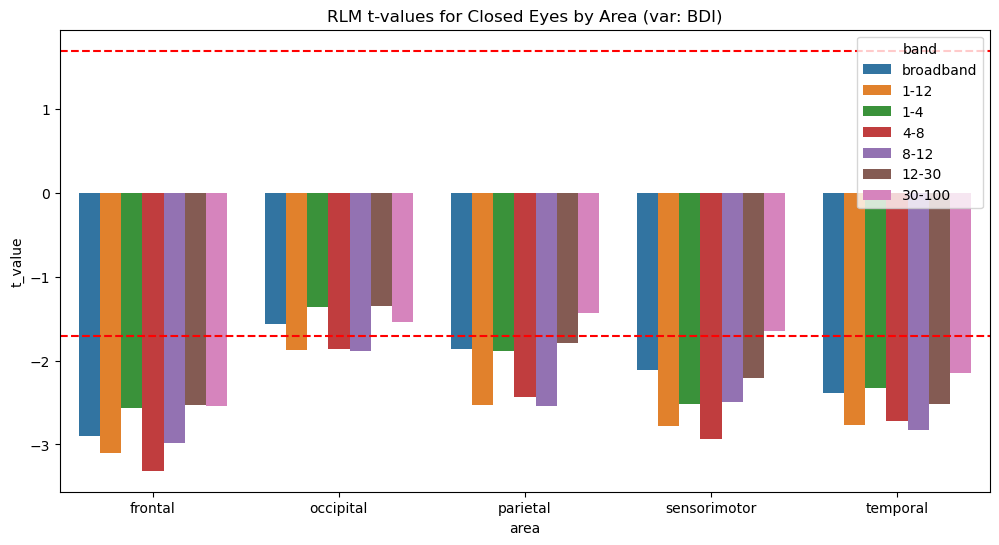

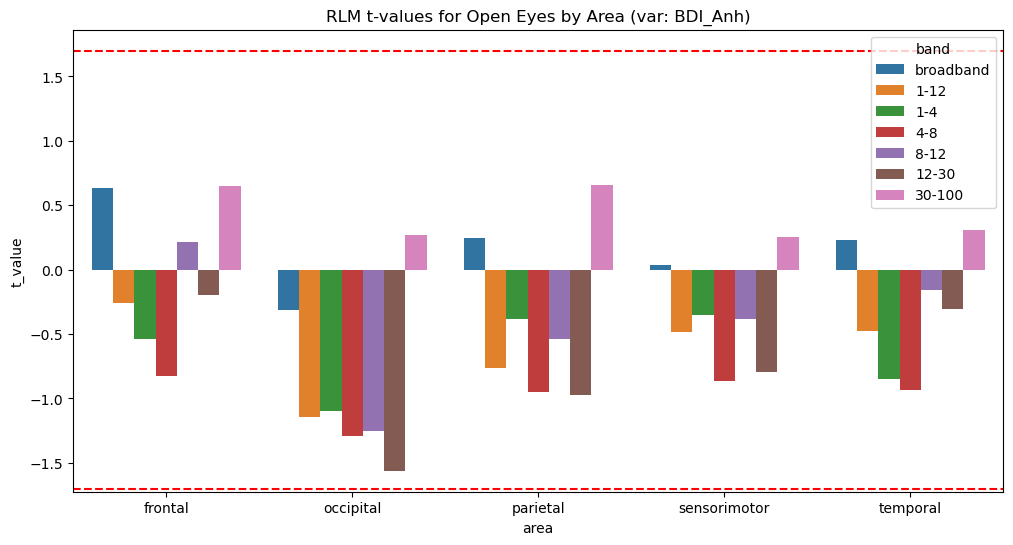

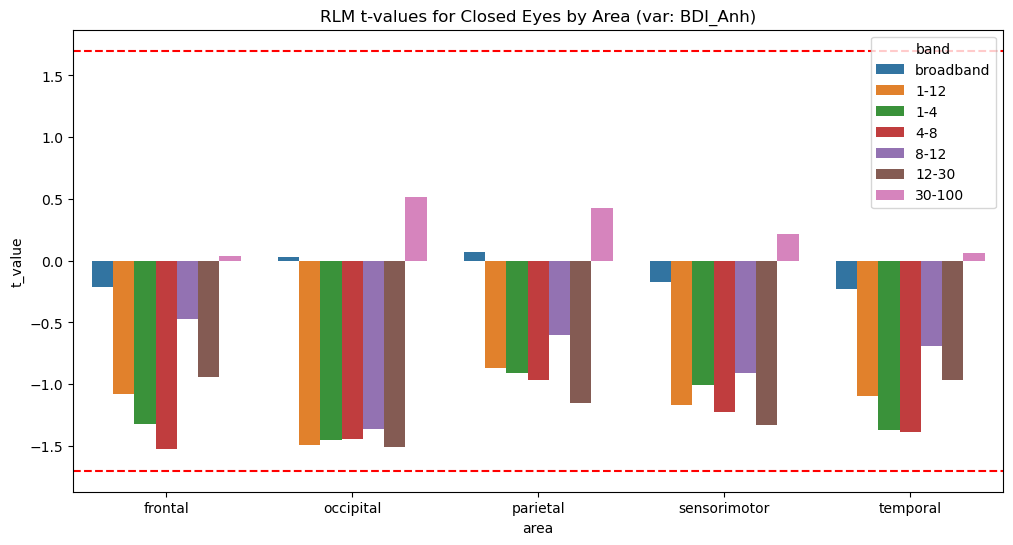

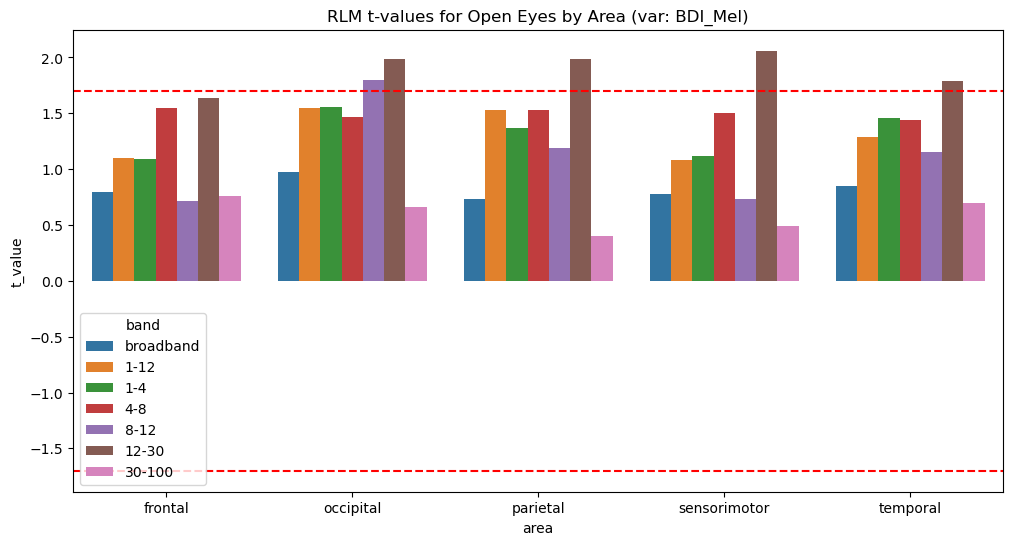

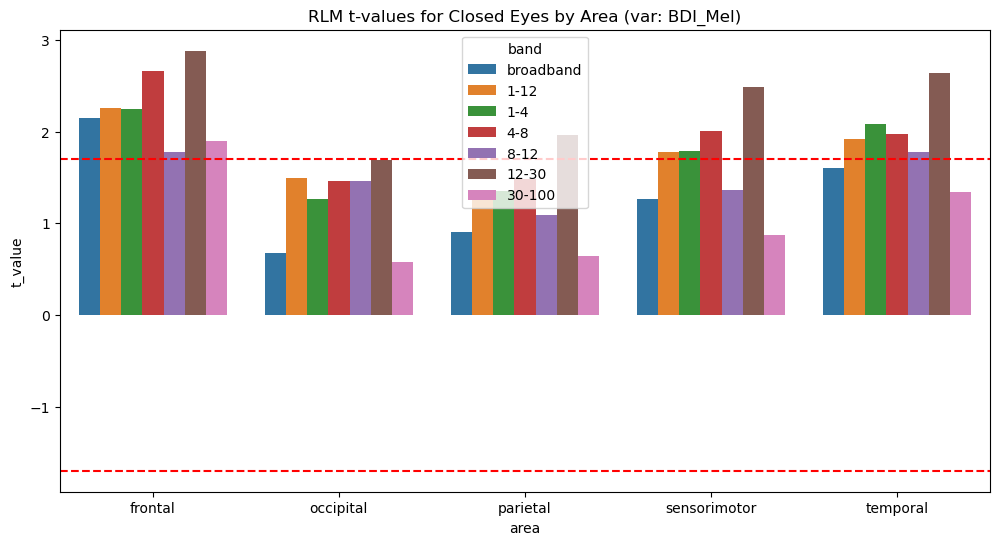

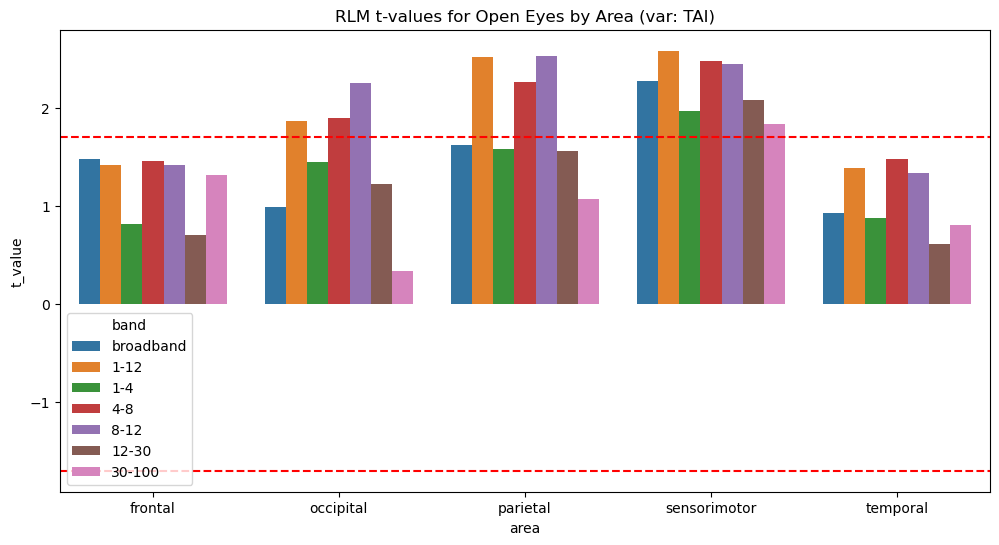

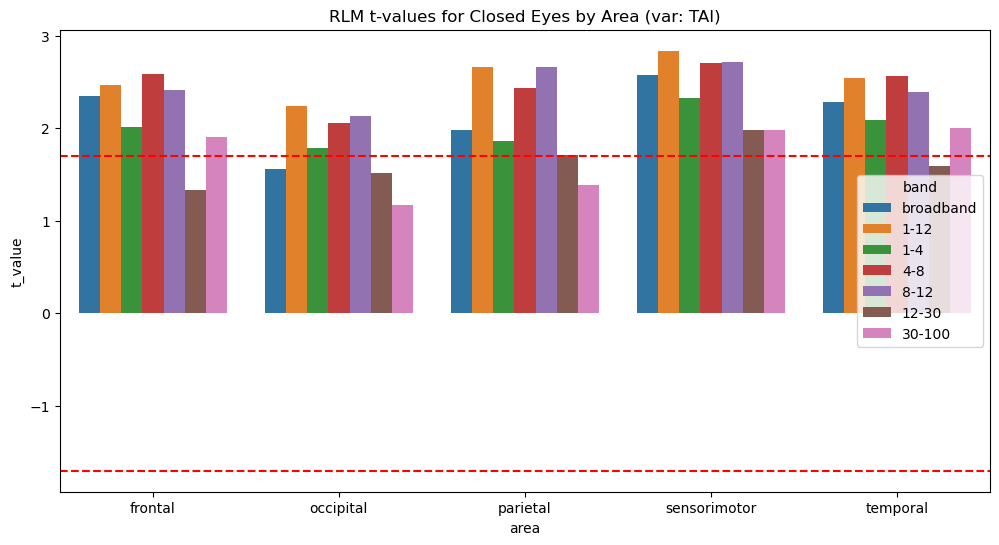

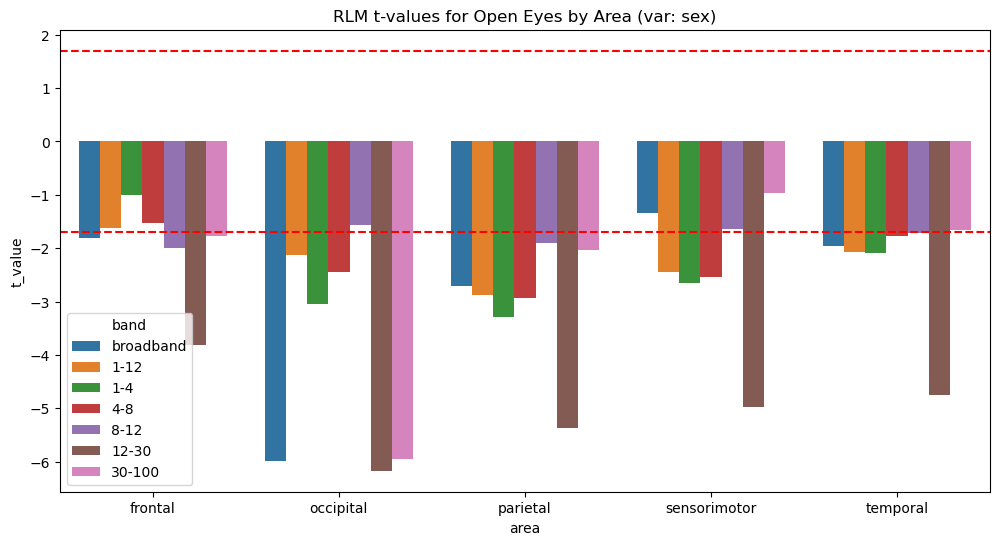

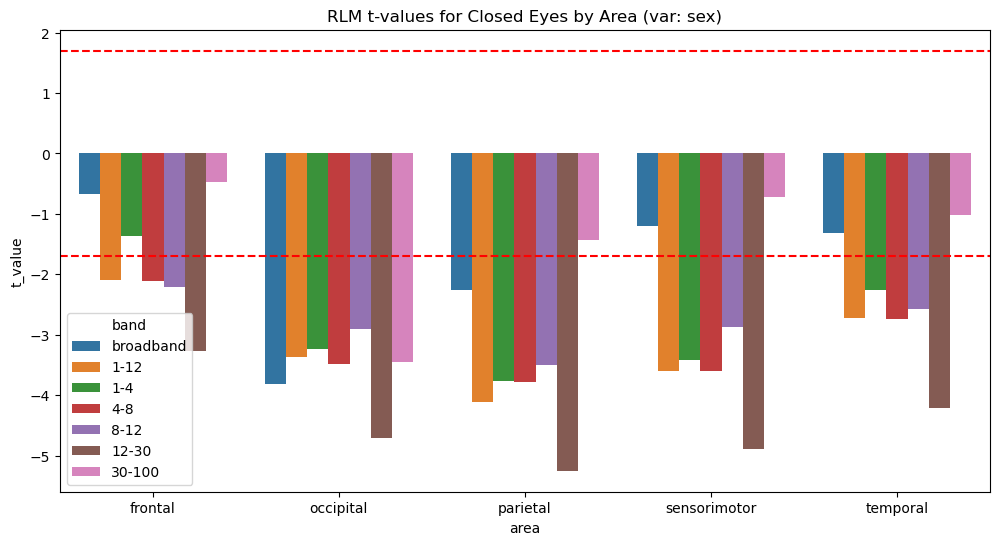

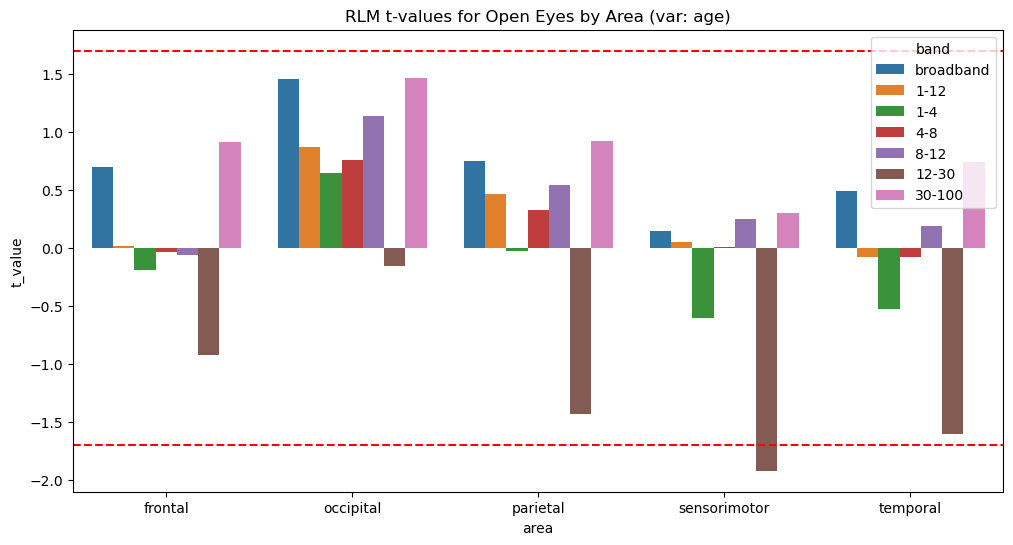

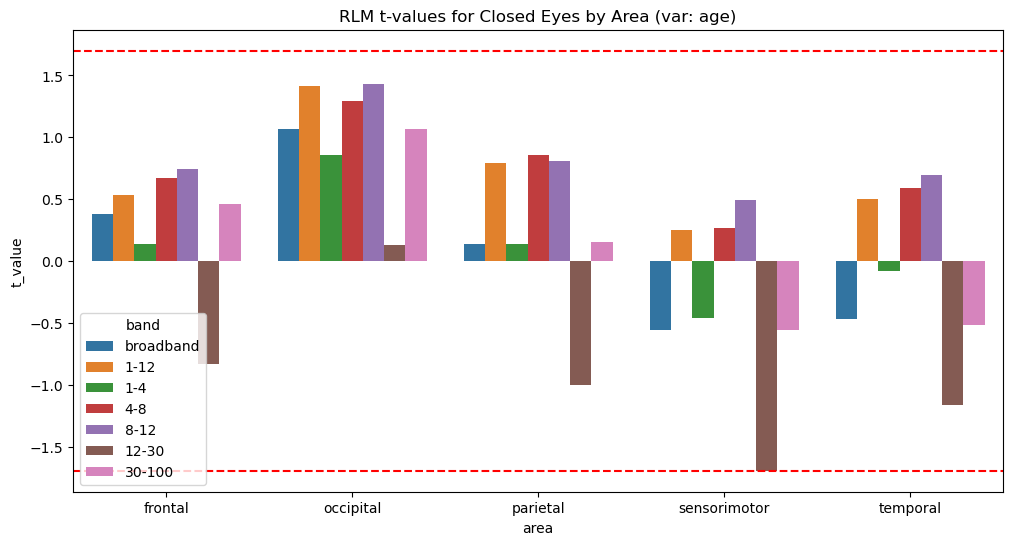

In [10]:
def barplot_significance(eyes, var):
    plt.figure(figsize=(12, 6))
    sns.barplot(data=rlm_results[(rlm_results['eyes'] == eyes) & (rlm_results['variable'] == var) & (rlm_results['area'].isin(region_map.keys()))],
                x='area', y='t_value', hue='band', errorbar=None)
    plt.title(f'RLM t-values for {str.capitalize(eyes)} Eyes by Area (var: {var})')
    plt.axhline(y=1.7, color='r', linestyle='--')
    plt.axhline(y=-1.7, color='r', linestyle='--')
    plt.show()
    

for var in variables:
    if var in ['intercept', 'age_squared']:
        continue
    barplot_significance('open', var)
    barplot_significance('closed', var)

In [11]:
df.drop(columns=['depressed'], inplace=True)

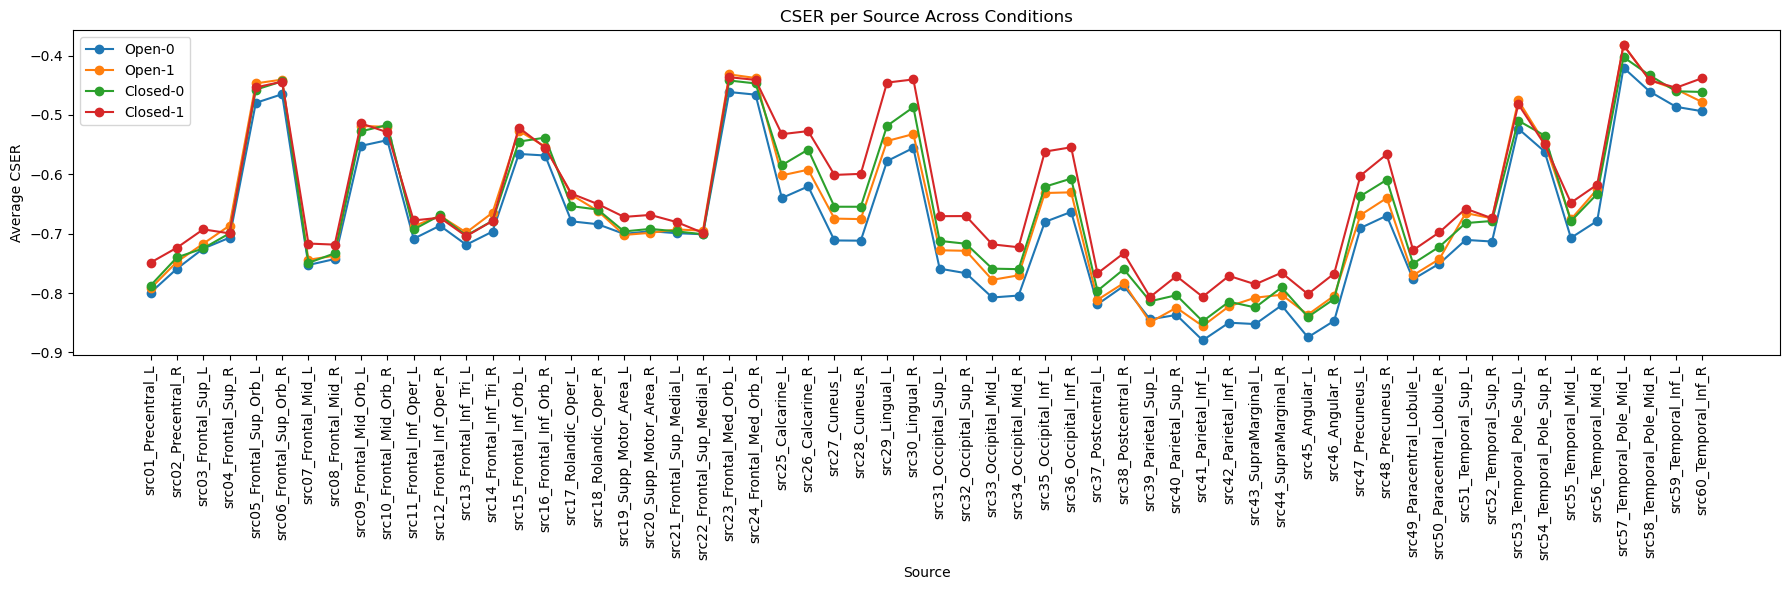

         id    eyes      area       band      CSER  MDD  sex   age   BDI  \
51408   559  closed     brain  broadband -2.798120    1  1.0  19.0  25.0   
51409   559  closed     brain       1-12 -0.095096    1  1.0  19.0  25.0   
51410   559  closed     brain        1-4 -0.021543    1  1.0  19.0  25.0   
51411   559  closed     brain        4-8 -0.042179    1  1.0  19.0  25.0   
51412   559  closed     brain       8-12 -0.031375    1  1.0  19.0  25.0   
...     ...     ...       ...        ...       ...  ...  ...   ...   ...   
119947  628    open  temporal        1-4 -0.013716    1  1.0  18.0  19.0   
119948  628    open  temporal        4-8 -0.031491    1  1.0  18.0  19.0   
119949  628    open  temporal       8-12 -0.023646    1  1.0  18.0  19.0   
119950  628    open  temporal      12-30 -0.249089    1  1.0  18.0  19.0   
119951  628    open  temporal     30-100 -0.992346    1  1.0  18.0  19.0   

        BDI_Anh  BDI_Mel   TAI  depressed  intercept  age_squared  
51408       7.0    

In [23]:
source_indices = np.arange(1, 61)

plt.figure(figsize=(18, 6))
for eyes in ['open', 'closed']:
    for depressed in df['depressed'].unique():
        mask = (df['eyes'] == eyes) & (df['depressed'] == depressed)
        avg = df.loc[mask, 'CSER'].groupby(df['area']).mean().reindex([f'src{i+1:02d}_{source_names[i]}' for i in range(60)])
        plt.plot(source_indices, avg, marker='o', label=f'{eyes.capitalize()}-{depressed}')

plt.xticks(source_indices, [f'src{idx+1:02d}_{source_names[idx]}' for idx in range(60)], rotation=90)
plt.xlabel('Source')
plt.ylabel('Average CSER')
plt.title('CSER per Source Across Conditions')
plt.legend()
plt.tight_layout()
plt.show()

df_test = df[(df['depressed'] == 1)].copy()
print(df_test)

In [ ]:
# Print significant t-values for each variable, eyes, brain region, and band
regions = list(region_map.keys())

for var in variables:
    if var in ['intercept', 'age_squared']:
        continue
    for eyes in ['open', 'closed']:
        print(f"\nVariable: {var}, Eyes: {eyes}")
        significance_found = False
        for region in regions:
            region_results = rlm_results[
                (rlm_results['variable'] == var) &
                (rlm_results['eyes'] == eyes) &
                (rlm_results['area'] == region) &
                (rlm_results['t_significant'])
            ]
            if not region_results.empty:
                significance_found = True
                print(f"  Region: {region}")
                for _, row in region_results.iterrows():
                    print(f"    Band: {row['band']}, t-value: {row['t_value']:.3f}")
        if not significance_found:
            print("  (no significant regions / bands)")


Variable: depressed, Eyes: open
  Region: frontal
    Band: 30-100, t-value: 4.118
  Region: occipital
    Band: broadband, t-value: 3.671
    Band: 1-12, t-value: 3.286
    Band: 4-8, t-value: 1.935
    Band: 8-12, t-value: -2.015
  Region: parietal
    Band: broadband, t-value: 3.106
    Band: 4-8, t-value: -1.752
    Band: 8-12, t-value: -2.912
    Band: 30-100, t-value: -3.884
  Region: sensorimotor
    Band: broadband, t-value: -1.924
    Band: 12-30, t-value: 3.106
  Region: temporal
    Band: 30-100, t-value: -1.811

Variable: depressed, Eyes: closed
  Region: frontal
    Band: broadband, t-value: -3.944
    Band: 4-8, t-value: -3.010
    Band: 8-12, t-value: -3.017
    Band: 30-100, t-value: -3.360
  Region: occipital
    Band: broadband, t-value: 2.697
  Region: parietal
    Band: 1-12, t-value: 2.293
    Band: 30-100, t-value: -2.651
  Region: sensorimotor
    Band: 4-8, t-value: -1.937

Variable: BDI, Eyes: open
  Region: frontal
    Band: broadband, t-value: -1.737
    Ban

In [ ]:
# Print all significant (t_significant) variables and bands for each region
for region in regions:
    print(f"\nRegion: {region}")
    region_results = rlm_results[
        (rlm_results['area'] == region) &
        (rlm_results['t_significant'] == True)
    ]
    if region_results.empty:
        print("  (no significant variables / bands)")
        continue
    for var in variables:
        if var in ['intercept', 'age_squared']:
            continue
        var_results = region_results[region_results['variable'] == var]
        if not var_results.empty:
            bands = var_results['band'].tolist()
            tvals = var_results['t_value'].tolist()
            print(f"  Variable: {var}")
            for band, tval in zip(bands, tvals):
                print(f"    Band: {band}, t-value: {tval:.3f}")


Region: frontal
  Variable: depressed
    Band: 30-100, t-value: 4.118
    Band: broadband, t-value: -3.944
    Band: 4-8, t-value: -3.010
    Band: 8-12, t-value: -3.017
    Band: 30-100, t-value: -3.360
  Variable: BDI
    Band: broadband, t-value: -1.737
    Band: 1-12, t-value: -1.988
    Band: 4-8, t-value: -2.094
    Band: 8-12, t-value: -1.947
    Band: 12-30, t-value: -1.708
    Band: broadband, t-value: -2.896
    Band: 1-12, t-value: -3.100
    Band: 1-4, t-value: -2.567
    Band: 4-8, t-value: -3.313
    Band: 8-12, t-value: -2.987
    Band: 12-30, t-value: -2.528
    Band: 30-100, t-value: -2.547
  Variable: BDI_Mel
    Band: broadband, t-value: 2.149
    Band: 1-12, t-value: 2.261
    Band: 1-4, t-value: 2.250
    Band: 4-8, t-value: 2.660
    Band: 8-12, t-value: 1.776
    Band: 12-30, t-value: 2.883
    Band: 30-100, t-value: 1.897
  Variable: TAI
    Band: broadband, t-value: 2.348
    Band: 1-12, t-value: 2.464
    Band: 1-4, t-value: 2.008
    Band: 4-8, t-value: 2.5

C:\Users\lukad\AppData\Local\Temp\ipykernel_24940\1181300551.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()


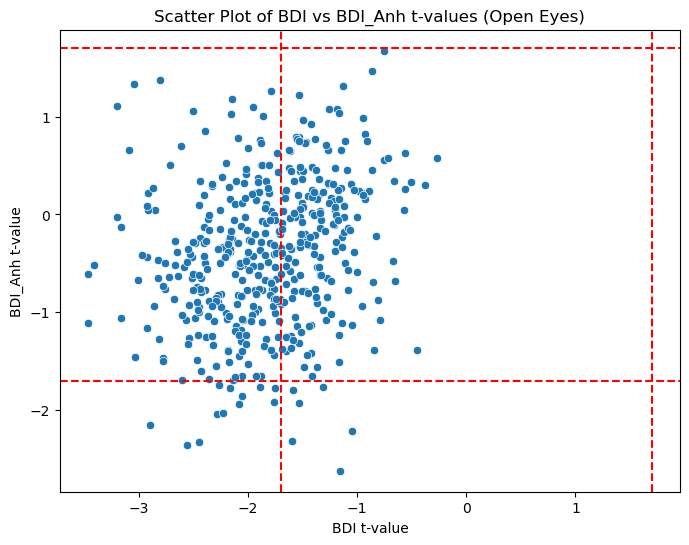

C:\Users\lukad\AppData\Local\Temp\ipykernel_24940\1181300551.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()


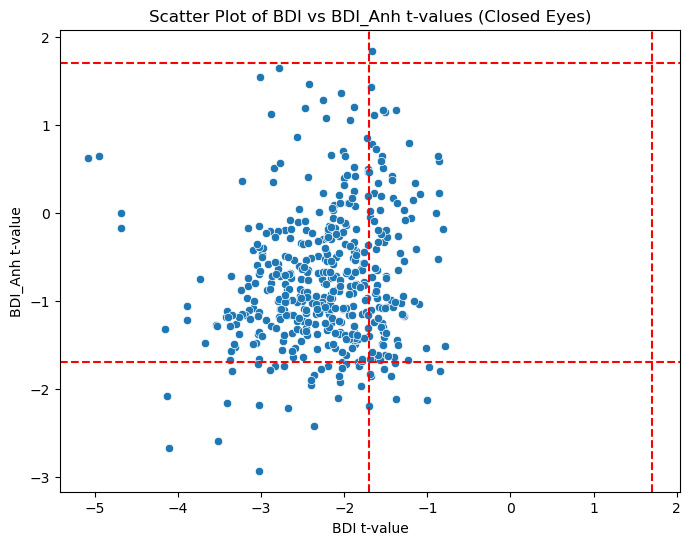

In [ ]:
# Generate a scatter plot for t_values of two variables

def scatter_plot_t_values(eyes, var1, var2):
    plt.figure(figsize=(8, 6))
    subset = (
        rlm_results[(rlm_results['eyes'] == eyes) & (rlm_results['variable'].isin([var1, var2]))]
        .pivot_table(index=['area', 'band'], columns='variable', values='t_value')
        .reset_index()
    )
    sns.scatterplot(data=subset, x=var1, y=var2)
    plt.title(f'Scatter Plot of {var1} vs {var2} t-values ({str.capitalize(eyes)} Eyes)')
    plt.xlabel(f'{var1} t-value')
    plt.ylabel(f'{var2} t-value')
    plt.axhline(y=1.7, color='r', linestyle='--')
    plt.axhline(y=-1.7, color='r', linestyle='--')
    plt.axvline(x=1.7, color='r', linestyle='--')
    plt.axvline(x=-1.7, color='r', linestyle='--')
    plt.legend().remove()
    plt.show()

var1 = 'BDI'
var2 = 'BDI_Anh'

# iterate through all combinations of vars in variables

scatter_plot_t_values('open', var1, var2)
scatter_plot_t_values('closed', var1, var2)


In [ ]:
significant_results = pd.DataFrame(columns=['variable', 'value', 'count', 'percentage'])

def count_significant_results(df, column):
    counts = df[column].value_counts()
    total = len(df)
    percentages = (counts / total) * 100
    percentages = percentages.round(2)
    return counts, percentages

for var in ['eyes', 'area', 'band']:
    counts, percentages = count_significant_results(rlm_results[rlm_results['p_significant']], var)

    counts_df = counts.to_frame(name='count')
    percentages_df = percentages.to_frame(name='percentage')
    merged_df = pd.merge(counts_df, percentages_df, left_index=True, right_index=True)

    print(merged_df, "\n")
    
    merged_df = merged_df.reset_index().rename(columns={var: 'value'})
    merged_df['variable'] = var
    significant_results = pd.concat([significant_results, merged_df], ignore_index=True)

print(significant_results)


        count  percentage
eyes                     
closed   1090       59.34
open      747       40.66 

                            count  percentage
area                                         
src20_Supp_Motor_Area_R        53        2.89
src19_Supp_Motor_Area_L        51        2.78
src24_Frontal_Med_Orb_R        50        2.72
src23_Frontal_Med_Orb_L        46        2.50
src21_Frontal_Sup_Medial_L     43        2.34
...                           ...         ...
src09_Frontal_Mid_Orb_L        14        0.76
src05_Frontal_Sup_Orb_L        14        0.76
src59_Temporal_Inf_L           14        0.76
src60_Temporal_Inf_R           13        0.71
src03_Frontal_Sup_L            12        0.65

[66 rows x 2 columns] 

           count  percentage
band                        
1-12         336       18.29
4-8          332       18.07
12-30        312       16.98
8-12         301       16.39
1-4          209       11.38
broadband    193       10.51
30-100       154        8.38 

   varia

C:\Users\lukad\AppData\Local\Temp\ipykernel_24940\4015498119.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  significant_results = pd.concat([significant_results, merged_df], ignore_index=True)


C:\Users\lukad\AppData\Local\Temp\ipykernel_24940\2211533162.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.hist(df[df['eyes'] == 'open'][df['area'] == 'brain'][df['band'] == 'broadband']['CSER'].dropna(), bins=30, alpha=0.5, color='blue', label='CSER Open')
C:\Users\lukad\AppData\Local\Temp\ipykernel_24940\2211533162.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.hist(df[df['eyes'] == 'open'][df['area'] == 'brain'][df['band'] == 'broadband']['CSER'].dropna(), bins=30, alpha=0.5, color='blue', label='CSER Open')
C:\Users\lukad\AppData\Local\Temp\ipykernel_24940\2211533162.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.hist(df[df['eyes'] == 'closed'][df['area'] == 'brain'][df['band'] == 'broadband']['CSER'].dropna(), bins=30, alpha=0.5, color='red', label='CSER Closed')
C:\Users\lukad\AppData\Local\Temp\ipykernel_24940\2211533162.py:3: UserWarning: Boolean Series ke

(array([ 1.,  0.,  0.,  1.,  2.,  1.,  1.,  2.,  3.,  8.,  4., 10.,  8.,
        11.,  7., 10., 15.,  7.,  6.,  8.,  2.,  4.,  0.,  0.,  2.,  1.,
         1.,  0.,  1.,  1.]),
 array([-3.35364316, -3.30807614, -3.26250912, -3.2169421 , -3.17137507,
        -3.12580805, -3.08024103, -3.03467401, -2.98910699, -2.94353996,
        -2.89797294, -2.85240592, -2.8068389 , -2.76127188, -2.71570485,
        -2.67013783, -2.62457081, -2.57900379, -2.53343677, -2.48786974,
        -2.44230272, -2.3967357 , -2.35116868, -2.30560166, -2.26003463,
        -2.21446761, -2.16890059, -2.12333357, -2.07776655, -2.03219952,
        -1.9866325 ]),
 <BarContainer object of 30 artists>)

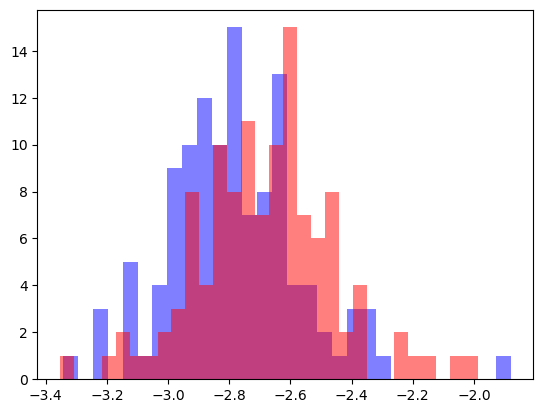

In [ ]:
# Plot the distribution of CSER values with eyes set to 'open' and 'closed'
plt.hist(df[df['eyes'] == 'open'][df['area'] == 'brain'][df['band'] == 'broadband']['CSER'].dropna(), bins=30, alpha=0.5, color='blue', label='CSER Open')
plt.hist(df[df['eyes'] == 'closed'][df['area'] == 'brain'][df['band'] == 'broadband']['CSER'].dropna(), bins=30, alpha=0.5, color='red', label='CSER Closed')

# Plot the distribution of CSER values with eyes set to 'open' and 'closed'
# plt.hist(df[df['depressed'] == 0]['CSER'].dropna(), bins=30, alpha=0.5, color='blue', label='CSER Open')
# plt.hist(df[df['depressed'] == 1]['CSER'].dropna(), bins=30, alpha=0.5, color='red', label='CSER Closed')